In [57]:

emotions = {
    "01" :  "ANG",
    "02" :  "NEU"



}


os.listdir('/Users/chow/Coding/Emotion_Detector/AudioWAV')


path = "/Users/chow/Coding/Emotion_Detector/AudioWAV/1022_ITS_ANG_XX.wav"

In [47]:
os.listdir('/Users/chow/Coding/Emotion_Detector/AudioWAV')

['1022_ITS_ANG_XX.wav',
 '1037_ITS_ANG_XX.wav',
 '1060_ITS_NEU_XX.wav',
 '1075_ITS_NEU_XX.wav',
 '1073_IOM_DIS_XX.wav',
 '1066_IOM_DIS_XX.wav',
 '1078_IWL_SAD_XX.wav',
 '1029_TAI_FEA_XX.wav',
 '1039_IEO_SAD_MD.wav',
 '1008_TAI_HAP_XX.wav',
 '1018_TSI_FEA_XX.wav',
 '1028_IEO_SAD_HI.wav',
 '1039_TSI_HAP_XX.wav',
 '1064_ITS_HAP_XX.wav',
 '1071_ITS_HAP_XX.wav',
 '1045_ITS_FEA_XX.wav',
 '1050_ITS_FEA_XX.wav',
 '1018_IWL_ANG_XX.wav',
 '1059_IEO_ANG_MD.wav',
 '1054_MTI_DIS_XX.wav',
 '1041_MTI_DIS_XX.wav',
 '1048_IEO_ANG_HI.wav',
 '1042_ITS_SAD_XX.wav',
 '1019_TAI_NEU_XX.wav',
 '1057_ITS_SAD_XX.wav',
 '1028_TSI_NEU_XX.wav',
 '1087_IOM_ANG_XX.wav',
 '1039_IEO_HAP_LO.wav',
 '1018_IEO_FEA_LO.wav',
 '1079_DFA_NEU_XX.wav',
 '1063_IWW_DIS_XX.wav',
 '1076_IWW_DIS_XX.wav',
 '1068_WSI_HAP_XX.wav',
 '1049_WSI_FEA_XX.wav',
 '1059_ITH_DIS_XX.wav',
 '1068_DFA_HAP_XX.wav',
 '1049_DFA_FEA_XX.wav',
 '1079_WSI_NEU_XX.wav',
 '1082_IWW_ANG_XX.wav',
 '1061_ITH_NEU_XX.wav',
 '1074_ITH_NEU_XX.wav',
 '1023_ITH_ANG_X

In [62]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# y is audio time series (Amplitude over time)
# sr is sampling rate, number of samples per sec (Hz)
y, sr = librosa.load(path, sr = 22050)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
# Converting into MFCCS
# mfccs = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 13) # n_mfcc is the number of mfcc

In [65]:
print(log_mel_spec.shape) # number of mel freq, T time step

(128, 105)


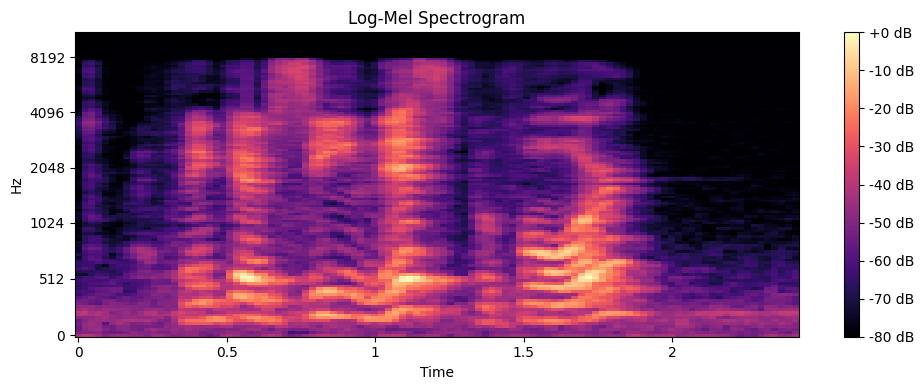

In [63]:
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spec, sr=sr, x_axis='time', y_axis='mel')
plt.title('Log-Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


In [69]:



y, sr = librosa.load(path, sr=None)  # load with original sampling rate
duration = librosa.get_duration(y=y, sr=sr)

print(f"Duration: {duration:.2f} seconds")

Duration: 2.44 seconds


In [70]:
import os

# Loop through all the files



In [92]:


cwd = os.getcwd() 
audio_path = os.path.join(cwd, "AudioWAV")
audio_wav = [f for f in os.listdir(audio_path) if f.lower().endswith('.wav')]

In [98]:

for wav_files in audio_wav:
    


7442
2.43575


['1022_ITS_ANG_XX.wav',
 '1037_ITS_ANG_XX.wav',
 '1060_ITS_NEU_XX.wav',
 '1075_ITS_NEU_XX.wav',
 '1073_IOM_DIS_XX.wav',
 '1066_IOM_DIS_XX.wav',
 '1078_IWL_SAD_XX.wav',
 '1029_TAI_FEA_XX.wav',
 '1039_IEO_SAD_MD.wav',
 '1008_TAI_HAP_XX.wav',
 '1018_TSI_FEA_XX.wav',
 '1028_IEO_SAD_HI.wav',
 '1039_TSI_HAP_XX.wav',
 '1064_ITS_HAP_XX.wav',
 '1071_ITS_HAP_XX.wav',
 '1045_ITS_FEA_XX.wav',
 '1050_ITS_FEA_XX.wav',
 '1018_IWL_ANG_XX.wav',
 '1059_IEO_ANG_MD.wav',
 '1054_MTI_DIS_XX.wav',
 '1041_MTI_DIS_XX.wav',
 '1048_IEO_ANG_HI.wav',
 '1042_ITS_SAD_XX.wav',
 '1019_TAI_NEU_XX.wav',
 '1057_ITS_SAD_XX.wav',
 '1028_TSI_NEU_XX.wav',
 '1087_IOM_ANG_XX.wav',
 '1039_IEO_HAP_LO.wav',
 '1018_IEO_FEA_LO.wav',
 '1079_DFA_NEU_XX.wav',
 '1063_IWW_DIS_XX.wav',
 '1076_IWW_DIS_XX.wav',
 '1068_WSI_HAP_XX.wav',
 '1049_WSI_FEA_XX.wav',
 '1059_ITH_DIS_XX.wav',
 '1068_DFA_HAP_XX.wav',
 '1049_DFA_FEA_XX.wav',
 '1079_WSI_NEU_XX.wav',
 '1082_IWW_ANG_XX.wav',
 '1061_ITH_NEU_XX.wav',
 '1074_ITH_NEU_XX.wav',
 '1023_ITH_ANG_X